### - 기본 설정 및 초기 데이터 정제 과정

In [1]:
# 최종 ver
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
from decimal import Decimal
import warnings
import plotly.graph_objects as go
import plotly.express as px

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import style
from plotly.subplots import make_subplots
from dateutil.easter import easter

import plotly.io as pio
import matplotlib
import matplotlib.font_manager as fm

In [52]:
# 맥 개발환경 한국어 설정을 위함.
import matplotlib as mpl
#by_60211642
print(mpl.matplotlib_fname())

# 맥 개발환경 한국어 설정을 위함.
font_path="./NanumGothicBold.ttf"
font_name=font_manager.FontProperties(fname=font_path).get_name()
rc("font",family=font_name)
#by_60211642

/opt/anaconda3/envs/SDA/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


In [49]:
#by_60211642
data = pd.read_csv("./코로나바이러스감염증-19_확진환자_발생현황_221126.csv", header = 0)
data.tail(10)

,일자,계(명),국내발생(명),해외유입(명),사망(명),Unnamed: 5,열2,열3,열4,열5,Unnamed: 10,Unnamed: 11
1033,2022.11.18,"49,399","49,333",66,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1034,2022.11.19,"50,568","50,518",50,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,2022.11.20,"45,998","45,940",58,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1036,2022.11.21,"23,077","23,016",61,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,2022.11.22,"72,860","72,779",81,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,2022.11.23,"70,306","70,237",69,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,2022.11.24,"59,082","59,027",55,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1040,2022.11.25,"53,698","53,659",39,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1041,2022.11.26,"52,788","52,726",62,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1042,누적(명),"26,890,488","26,819,311","71,177","30,330",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df_covid = data.loc[:,['일자','계(명)','사망(명)']][:1042]
df_temp = data.loc[:,['일자','계(명)','사망(명)']][:1042]

df_covid3 = data.loc[:,['일자','계(명)','사망(명)']][57:1042]
df_covid2 = df_covid = data.loc[:,['일자','계(명)','사망(명)']][:1042]

df_covid['일자'] = pd.to_datetime(df_covid['일자'], format='%Y-%m-%d')
df_temp['일자'] = pd.to_datetime(df_temp['일자'], format='%Y-%m-%d')

df_covid.isna().sum()
df_covid = df_covid.replace("-", 0)
df_temp.isna().sum()
df_temp = df_temp.replace("-", 0)

### - 집단감염 사례 제거 과정

In [54]:
pat_all = pd.read_csv("PatientInfo.csv")

# 감염case가 contact with patient 인 데이터 추출
pat_from_pat = pat_all.loc[pat_all['infection_case']=="contact with patient"]

# pat_from_pat1 : 감염자
pat_from_pat1 = pat_from_pat[['patient_id']]
pat_from_pat1 = pat_from_pat1.reset_index()
pat_from_pat1 = pat_from_pat1.drop(['index'],axis=1)
# pat_from_pat[['infected_by']] = pd.to_numeric(pat_from_pat['infected_by'])

# pat_from_pat2 : 전파자
pat_from_pat2 = pat_from_pat[['infected_by']] #환자
pat_from_pat2 = pat_from_pat2.reset_index()
pat_from_pat2 = pat_from_pat2.drop(['index'],axis=1)

### - 집단감염 사례에서의 n차 감염자까지 제거

In [55]:
def make_list(event_name): #event_name : infection_case 이름
   
    #event_name의 환자 추출
    pat_event = pat_all.loc[pat_all['infection_case']==event_name]
    pat_event_id = pat_event[['patient_id']]
    pat_event_id = pat_event_id.reset_index()
    pat_event_id = pat_event_id.drop(['index'],axis=1)
    
    #event_name의 환자 list화
    from_event_id =[]
    for i in range(len(pat_event_id)):
        from_event_id.append(pat_event_id['patient_id'][i])
    by_id = []
    for i in range(len(pat_from_pat2)):
        by_id.append(pat_from_pat2['infected_by'][i])
        
    #while문 탈출 조건    
    n= 0
    m =0
    
    #event_name의 감염자 및 n차 감염자 추출
    while(True):
        n =len(from_event_id)
        
        #event_name의 감염자 id와 pat_from_pat의 전파자 id가 같으면 list에 저장
        for i in range(len(from_event_id)):
            for j in range(len(by_id)):
                if(by_id[j]==from_event_id[i]):
                    from_event_id.append(pat_from_pat1['patient_id'][j])
                    from_event_id = list(set(from_event_id)) #중복제거
        
        m =len(from_event_id)
        
        #더이상 n차 감염자가 없다면 while문 탈출
        if (n==m):
            break
            
    pat_res= pat_all
    idx_nm1 = []
    
    #전체 환자에서 event_name의 모든 감염자(n차 감염자 포함) 제거
    for i in range(len(from_event_id)):
        idx_nm1.append(pat_all[pat_all['patient_id']==from_event_id[i]].index)

    for j in range(len(idx_nm1)):
        pat_res = pat_res.drop(idx_nm1[j])
        
    #n차 감염자까지 제거 후 데이터와 감염자 id list 출력
    return pat_res, from_event_id

In [56]:
def make_plot(df_name):
    pc = df_name.groupby(['confirmed_date']).size().reset_index(name='count')
    pc['confirmed_date'] = pd.to_datetime(pc['confirmed_date'], format='%Y-%m-%d')
    return pc

def make_csum_plot(df_name):
    pc = df_name.groupby(['confirmed_date']).size().cumsum().reset_index(name='count')
    pc['confirmed_date'] = pd.to_datetime(pc['confirmed_date'], format='%Y-%m-%d')
    return pc

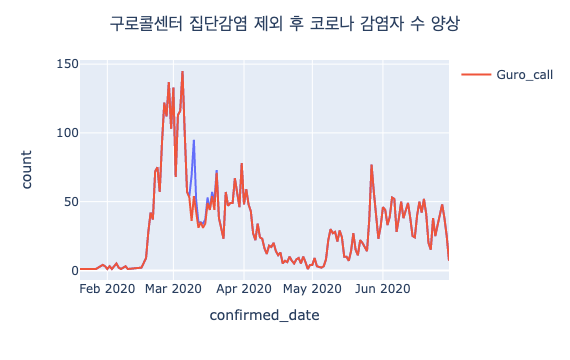

In [57]:
#구로 데이터 비교
pat_guro, k = make_list('Guro-gu Call Center')

pc_all = make_plot(pat_all)
pc_guro = make_plot(pat_guro)
fig1 = px.line(pc_all, x = 'confirmed_date', y = 'count')
fig1.add_scatter(x=pc_guro['confirmed_date'], y = pc_guro['count'], name = 'Guro_call')
fig1.update_layout(
    title={
        'text': "구로콜센터 집단감염 제외 후 코로나 감염자 수 양상",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig1.show()

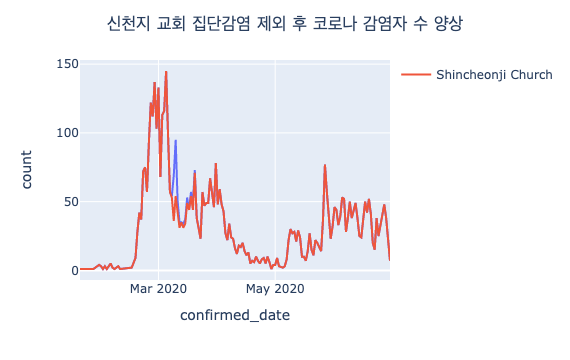

In [58]:
#신천지 데이터 비교
pat_shin ,m= make_list('Shincheonji Church')

pc_all = make_plot(pat_all)
pc_shin = make_plot(pat_guro)
fig1 = px.line(pc_all, x = 'confirmed_date', y = 'count')
fig1.add_scatter(x=pc_shin['confirmed_date'], y = pc_shin['count'], name = 'Shincheonji Church')
fig1.update_layout(
    title={
        'text': "신천지 교회 집단감염 제외 후 코로나 감염자 수 양상",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig1.show()

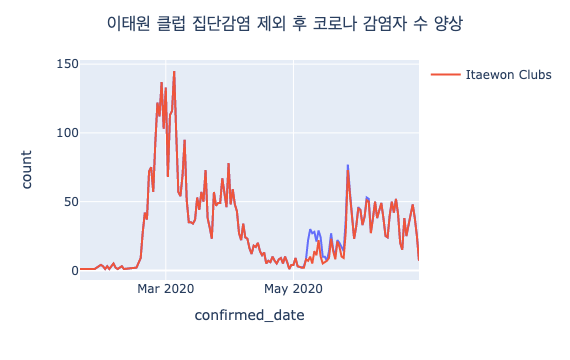

In [59]:
#이태원클럽 데이터 비교
pat_itaewon , n= make_list('Itaewon Clubs')

pc_all = make_plot(pat_all)
pc_itaewon = make_plot(pat_itaewon)
fig1 = px.line(pc_all, x = 'confirmed_date', y = 'count')
fig1.add_scatter(x=pc_itaewon['confirmed_date'], y = pc_itaewon['count'], name = 'Itaewon Clubs')
fig1.update_layout(
    title={
        'text': "이태원 클럽 집단감염 제외 후 코로나 감염자 수 양상",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig1.show()

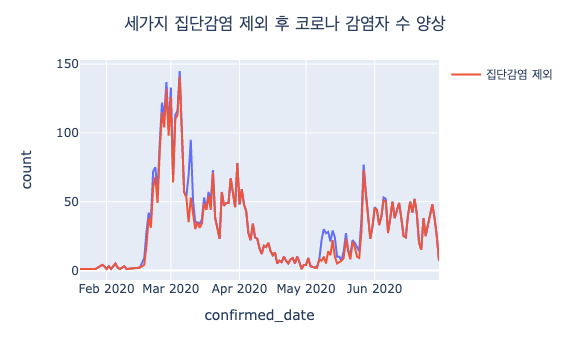

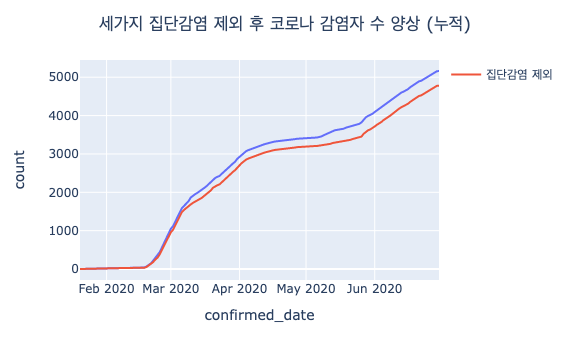

In [60]:
a = [k, n, m]

#pat_res : 세가지 집단감염자 모두 제거한 데이터
pat_res= pat_all
for b in range(len(a)):
    c = a[b]
    idx_nm1 = []
    for i in range(len(c)):
        idx_nm1.append(pat_all[pat_all['patient_id']==c[i]].index)

    for j in range(len(idx_nm1)):
        pat_res = pat_res.drop(idx_nm1[j])
        
pc_all = make_plot(pat_all)
pc_res = make_plot(pat_res)

pc_csum_all = make_csum_plot(pat_all)
pc_csum_res = make_csum_plot(pat_res)

fig1 = px.line(pc_all, x = 'confirmed_date', y = 'count')
fig1.add_scatter(x=pc_res['confirmed_date'], y = pc_res['count'], name = '집단감염 제외')
fig1.update_layout(
    title={
        'text': "세가지 집단감염 제외 후 코로나 감염자 수 양상",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig1.show()

fig2 = px.line(pc_csum_all, x = 'confirmed_date', y = 'count')
fig2.add_scatter(x=pc_csum_res['confirmed_date'], y = pc_csum_res['count'], name = '집단감염 제외')
fig2.update_layout(
    title={
        'text': "세가지 집단감염 제외 후 코로나 감염자 수 양상 (누적)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig2.show()

### - 초기 데이터를 집단감염 제거 데이터로 교체하기

In [61]:
pc_res.rename(columns = {'count':'계(명)'}, inplace=True)
pc_res.rename(columns = {'confirmed_date':'일자'}, inplace=True)
pc_res['일자'] = pd.to_datetime(pc_res['일자'], format='%Y-%m-%d')
pc_res

,일자,계(명)
0,2020-01-20,1
1,2020-01-23,1
2,2020-01-26,1
3,2020-01-27,1
4,2020-01-30,4
...,...,...
143,2020-06-26,40
144,2020-06-27,48
145,2020-06-28,38
146,2020-06-29,25


In [62]:
for i, pc in enumerate(pc_res['일자']) :
    for j, co in enumerate(df_covid['일자']):
        if pc.value == co.value:
            df_covid["계(명)"][j] = int(pc_res["계(명)"][i])
            break
print(df_temp.head(20))
print(df_covid.head(20))

           일자 계(명) 사망(명)
0  2020-01-20   1      0
1  2020-01-21   0      0
2  2020-01-22   0      0
3  2020-01-23   0      0
4  2020-01-24   1      0
5  2020-01-25   0      0
6  2020-01-26   1      0
7  2020-01-27   1      0
8  2020-01-28   0      0
9  2020-01-29   0      0
10 2020-01-30   3      0
11 2020-01-31   4      0
12 2020-02-01   1      0
13 2020-02-02   3      0
14 2020-02-03   0      0
15 2020-02-04   1      0
16 2020-02-05   5      0
17 2020-02-06   3      0
18 2020-02-07   0      0
19 2020-02-08   0      0
           일자 계(명) 사망(명)
0  2020-01-20    1     0
1  2020-01-21   0      0
2  2020-01-22   0      0
3  2020-01-23    1     0
4  2020-01-24   1      0
5  2020-01-25   0      0
6  2020-01-26    1     0
7  2020-01-27    1     0
8  2020-01-28   0      0
9  2020-01-29   0      0
10 2020-01-30    4     0
11 2020-01-31    3     0
12 2020-02-01    1     0
13 2020-02-02    3     0
14 2020-02-03    1     0
15 2020-02-04   1      0
16 2020-02-05    5     0
17 2020-02-06    2     0


/var/folders/p7/570vhrqx0qs082gkv7y5wy780000gn/T/ipykernel_3183/34596000.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### - 데이터 추가, 누적 확진자, 누적 사망자, 감염률, 치명률

In [63]:
df_covid=df_covid.set_index('일자')
df_temp=df_temp.set_index('일자')

In [64]:
#누적 확진자 수 구하는 코드
df_covid["누적 확진자 수"] = df_covid["계(명)"]
df_temp["누적 확진자 수"] = df_temp["계(명)"]

def cumulative_number(i,df_name):
    if i == 0:
        df_name["누적 확진자 수"][0] = int(df_name["계(명)"][0])
    else:
        if (type(df_name["계(명)"][i]) != int):
            p = df_name["계(명)"][i].split(",")
            str_confirmed = ""
            num_confirmed = 0
            for j in range(len(p)):
                str_confirmed+=p[j]
            df_name["계(명)"][i] = int(str_confirmed)
            
        df_name["누적 확진자 수"][i] = int(df_name["누적 확진자 수"][i-1]) + df_name["계(명)"][i]

for i in range(len(df_covid)):
    cumulative_number(i,df_covid)
for i in range(len(df_temp)):
    cumulative_number(i,df_temp)

In [65]:
#누적 사망자 수 구하는 코드
df_covid["누적 사망자 수"] = df_covid["계(명)"]
df_temp["누적 사망자 수"] = df_temp["계(명)"]
def cumulative_number2(i,df_name):
    if i == 0:
        df_name["누적 사망자 수"][0] = int(df_name["사망(명)"][0])
    else:
        if type(df_name["사망(명)"][i]) != int :
            p = df_name["사망(명)"][i].split(",")
            str_confirmed = ""
            num_confirmed = 0
            for j in range(len(p)):
                str_confirmed+=p[j]
            df_name["사망(명)"][i] = int(str_confirmed)
            
        df_name["누적 사망자 수"][i] = int(df_name["누적 사망자 수"][i-1]) + df_name["사망(명)"][i]

for i in range(len(df_covid)):
    cumulative_number2(i,df_covid)
for i in range(len(df_temp)):
    cumulative_number2(i,df_temp)    

In [66]:
#감염률 구하는 코드
df_covid["감염률"] = df_covid["계(명)"]
df_temp["감염률"] = df_temp["계(명)"]
def infection_rate(i,df_name):
    rok_pop = 51628117
    if i == 0:
        df_name["감염률"][0] = int(df_name["계(명)"][0])/rok_pop
    else:
        #분모 (전체 국민 - 당일의 누적 확진자 수)
        denominator = (rok_pop - df_name["누적 확진자 수"][i-1])
        #분자 (당일의 확진자 수)
        numerator = df_name["계(명)"][i]
        p_infection = numerator/denominator
        df_name["감염률"][i] = p_infection
            
    
for i in range(len(df_covid)):
    infection_rate(i,df_covid)
for i in range(len(df_temp)):
    infection_rate(i,df_temp)    

In [67]:
#치명률 구하는 코드
df_covid["치명률"] = df_covid["누적 사망자 수"]
df_temp["치명률"] = df_temp["누적 사망자 수"]
def death_rate(i,df_name):
    if i <17:
        df_name["치명률"][0] = 0
    else:
        #분자 (누적 사망자 수)
        #분모 (17일 전 누적 확진자 수)
        p_lethality = int(df_name["누적 사망자 수"][i])/int(df_name["누적 확진자 수"][i-17])
        df_name["치명률"][i] = p_lethality
            
    
for i in range(len(df_covid)):
    death_rate(i,df_covid)
for i in range(len(df_temp)):
    death_rate(i,df_temp)

### - 데이터 추가 수정

In [90]:
#column 이름 명확하게 바꿈 (by60211642)
df_covid.rename(columns = {'계(명)':'일일 확진자 수'}, inplace=True)
df_covid.rename(columns = {'사망(명)':'일일 사망자 수'}, inplace=True)

df_temp.rename(columns = {'계(명)':'일일 확진자 수'}, inplace=True)
df_temp.rename(columns = {'사망(명)':'일일 사망자 수'}, inplace=True)

df_covid_rmOutlier = df_covid.loc['2020.3.17':]

### - 수정 데이터 vs 수정 전 데이터 비교

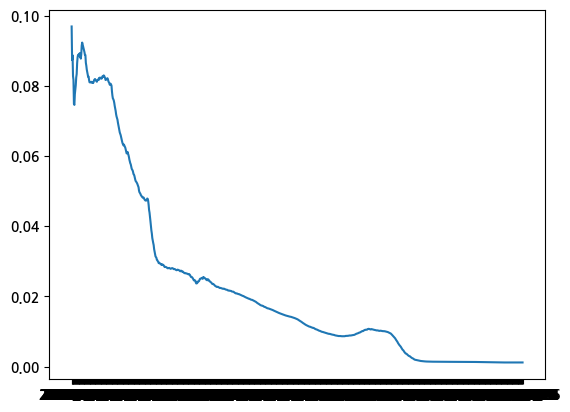

In [92]:
plt.plot(df_covid3['일자'], df_covid_rmOutlier['치명률'])
plt.show()

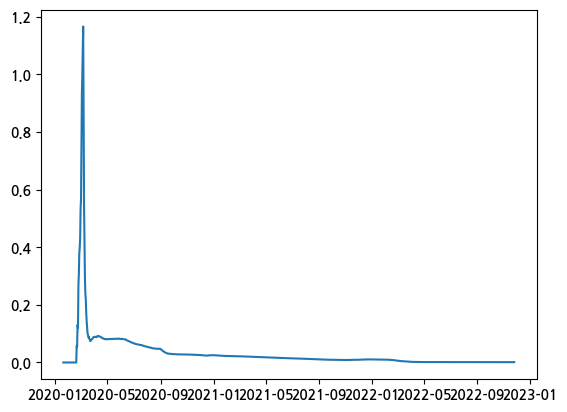

In [69]:
plt.plot(df_covid2['일자'], df_covid['치명률'])
plt.show()

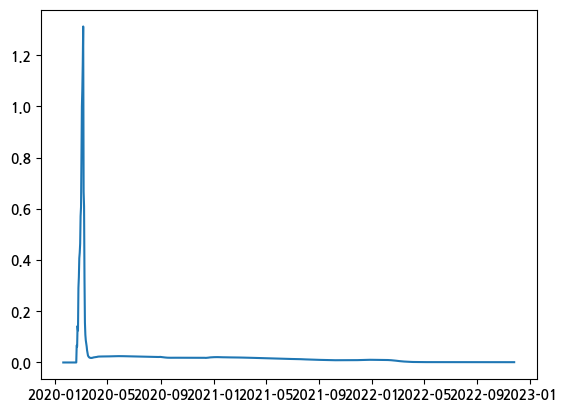

In [70]:
plt.plot(df_covid2['일자'], df_temp['치명률'])
plt.show()

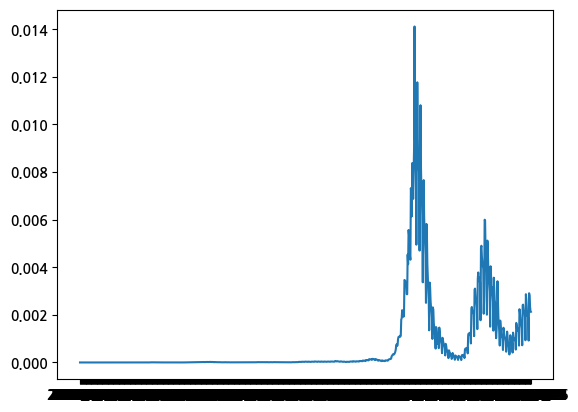

In [91]:
plt.plot(df_covid3['일자'], df_covid_rmOutlier['감염률'])
plt.show()

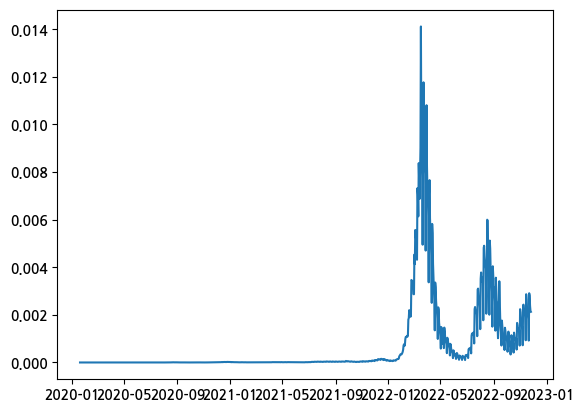

In [71]:
plt.plot(df_covid2['일자'], df_covid['감염률'])
plt.show()

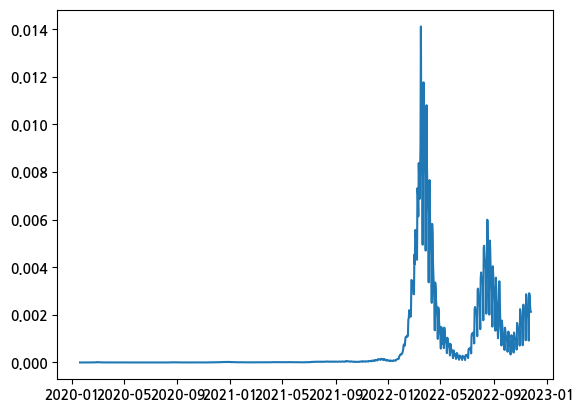

In [72]:
plt.plot(df_covid2['일자'], df_temp['감염률'])
plt.show()

### - 분포가 서로 같은지 비교

In [94]:
print("[1. 2차 실험 감염률 데이터 분석]")
t_stat, pval = stats.kstest(df_covid["감염률"], df_temp['감염률'])

print("이상치 제거 없음과 KS test : {}, p-value : {}".format(t_stat, pval))

t_stat, pval = stats.kstest(df_covid_rmOutlier["감염률"], df_covid['감염률'])

print("신천지 데이터 제거와 KS test : {}, p-value : {}".format(t_stat, pval))

[1. 2차 실험 감염률 데이터 분석]
이상치 제거 없음과 KS test : 0.0345489443378119, p-value : 0.5630291856169715
신천지 데이터 제거와 KS test : 0.04309556982374777, p-value : 0.29228665913646174


In [96]:
print("[1. 2차 실험 치명률 데이터 분석]")
t_stat, pval = stats.kstest(df_covid["치명률"], df_temp['치명률'])

print("이상치 제거 없음과 KS test : {}, p-value : {}".format(t_stat, pval))

t_stat, pval = stats.kstest(df_covid_rmOutlier["치명률"], df_covid['치명률'])

print("신천지 데이터 제거와 KS test : {}, p-value : {}".format(t_stat, pval))

[1. 2차 실험 치명률 데이터 분석]
이상치 제거 없음과 KS test : 0.2696737044145873, p-value : 9.916277545251918e-34
신천지 데이터 제거와 KS test : 0.029750479846449136, p-value : 0.7451170727582392


### - 전체 데이터 감염률, 치명률 정규성 검정

In [104]:
test_stat, p_val = stats.shapiro(df_covid['감염률'])
print("감염률 Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid['치명률'])
print("치명률 Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))

감염률 Shapiro Test-statistics : 0.49005502462387085, p-value : 0.0
치명률 Shapiro Test-statistics : 0.287492573261261, p-value : 0.0


### - etc, delta, omi plot

In [86]:
# 이상치 전체 제거 
df_covid_etc = df_covid.loc[:"2021.7.31"]
df_covid_delta = df_covid.loc["2021.8.1":"2022.1.24"]
df_covid_omi = df_covid.loc["2022.1.25":]
# 이상치 제거 없음
df2_covid_etc = df_temp.loc[:"2021.7.31"]
df2_covid_delta = df_temp.loc["2021.8.1":"2022.1.24"]
df2_covid_omi = df_temp.loc["2022.1.25":]

/opt/anaconda3/envs/SDA/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



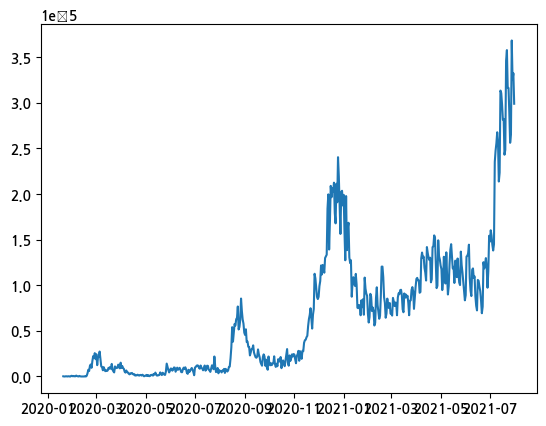

In [83]:
plt.plot(df_covid_etc['감염률'])
plt.show()

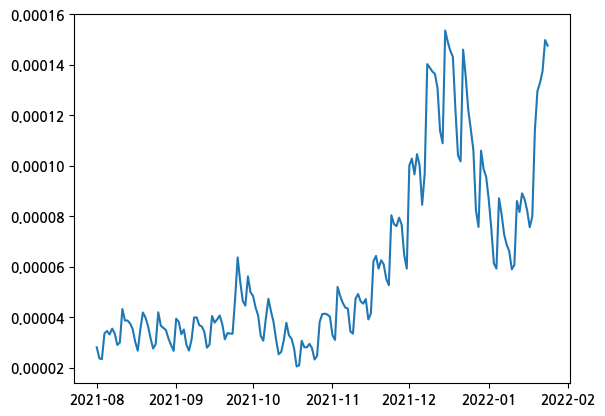

In [84]:
plt.plot(df_covid_delta['감염률'])
plt.show()

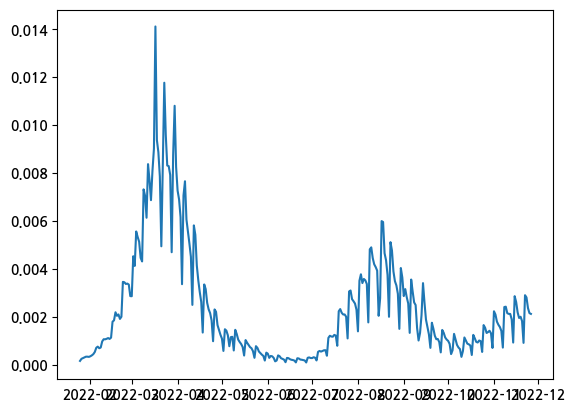

In [85]:
plt.plot(df_covid_omi['감염률'])
plt.show()

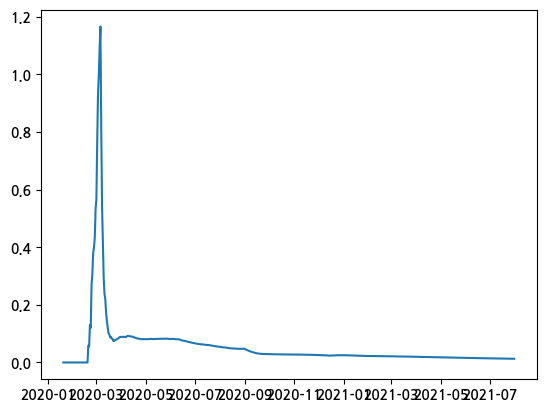

In [97]:
plt.plot(df_covid_etc['치명률'])
plt.show()

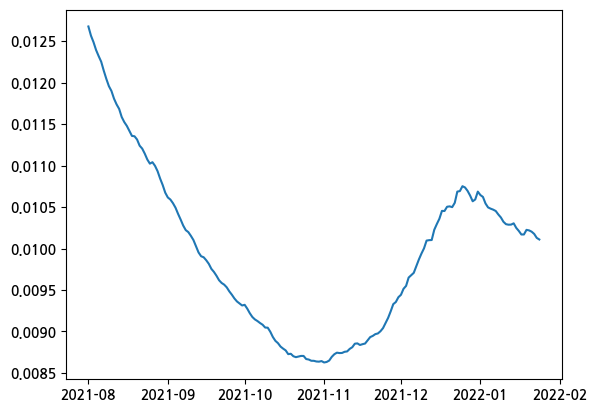

In [98]:
plt.plot(df_covid_delta['치명률'])
plt.show()

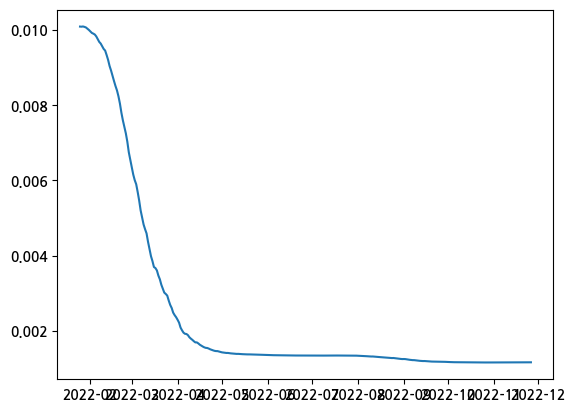

In [99]:
plt.plot(df_covid_omi['치명률'])
plt.show()

### - 2차 실험 진행 : 이상치 제거 데이터로 진행

In [100]:
#정규성 검증
print("[1. 2차실험 감염률 데이터 분석]")
print("[감염률 정규성 검증]")
test_stat, p_val = stats.shapiro(df_covid_etc["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_delta["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_omi["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()
print("[감염률 등분산 검증]")

test_stat, p_val = stats.fligner(df_covid_etc["감염률"],df_covid_delta["감염률"],df_covid_omi["감염률"])
print("Fligner Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()
#정규성을 만족하지 않으므로 Kruskal-Wallis Test 실행
print("[감염률 Kruskal-Wallis Test]")
test_stat, p_val = stats.kruskal(df_covid_etc["감염률"], df_covid_delta["감염률"], df_covid_omi["감염률"])
print("Kruskal-Wallis Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()

[1. 2차실험 감염률 데이터 분석]
[감염률 정규성 검증]
Shapiro Test-statistics : 0.8239768147468567, p-value : 2.6924469561135414e-24
Shapiro Test-statistics : 0.8355443477630615, p-value : 7.483093463454826e-13
Shapiro Test-statistics : 0.8051600456237793, p-value : 7.111323941894546e-19

[감염률 등분산 검증]
Fligner Test-statistics : 738.2296005975451, p-value : 4.9599699054499084e-161

[감염률 Kruskal-Wallis Test]
Kruskal-Wallis Test-statistics : 843.910687056595, p-value : 5.586279949873831e-184



In [101]:
#2 치명률 데이터 분석 
print("[2. 2차 실험 치명률 데이터 분석]")
#타입변환
df_covid_etc = df_covid_etc.astype({'치명률' : 'float'})
df_covid_delta = df_covid_delta.astype({'치명률' : 'float'})
df_covid_omi = df_covid_omi.astype({'치명률' : 'float'})

#정규성 검증
print("[치명률 정규성 검증]")
test_stat, p_val = stats.shapiro(df_covid_etc["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_delta["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_omi["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()

#등분산 검증
print("[치명률 등분산 검증]")
# 정규분포 아닐 시 bartlett사용 불가 -> non-parametric method인 fligner test 사용(by 60211642)
test_stat, p_val = stats.fligner(df_covid_etc["치명률"],df_covid_delta["치명률"],df_covid_omi["치명률"])
print("Fligner Test-statistics : {}, p-value : {}".format(test_stat, p_val))

#정규성을 만족하지 않으므로 Kruskal-Wallis Test 실행
print("[치명률 Kruskal-Wallis Test]")
test_stat, p_val = stats.kruskal(df_covid_etc["치명률"], df_covid_delta["치명률"], df_covid_omi["치명률"])
print("Kruskal-Wallis Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()

[2. 2차 실험 치명률 데이터 분석]
[치명률 정규성 검증]
Shapiro Test-statistics : 0.3306838274002075, p-value : 7.826952572486266e-41
Shapiro Test-statistics : 0.9401803612709045, p-value : 9.566617791278986e-07
Shapiro Test-statistics : 0.5527125000953674, p-value : 3.0214849858232097e-27

[치명률 등분산 검증]
Fligner Test-statistics : 499.17347377856834, p-value : 4.0351289015256053e-109
[치명률 Kruskal-Wallis Test]
Kruskal-Wallis Test-statistics : 677.2507188012573, p-value : 8.647189566037621e-148

